This notebook specifically uses the Photo Metadata (and not the Pawpularity score) with the aim of building a supplementary model as stated in the competition Data Description.

- **'You may use these labels as you see fit, and optionally build an intermediate / supplementary model to predict the labels from the photos. If your supplementary model is good, we may integrate it into our AI tools as well.**

- **In our production system, new photos that are dynamically scored will not contain any photo labels. If the Pawpularity prediction model requires photo label scores, we will use an intermediary model to derive such parameters, before feeding them to the final model.'**

So this will be treated as a 'multi-label' classification problem where each test image will be used to predict the labels and then from the labels predict the **pawpularity** score.

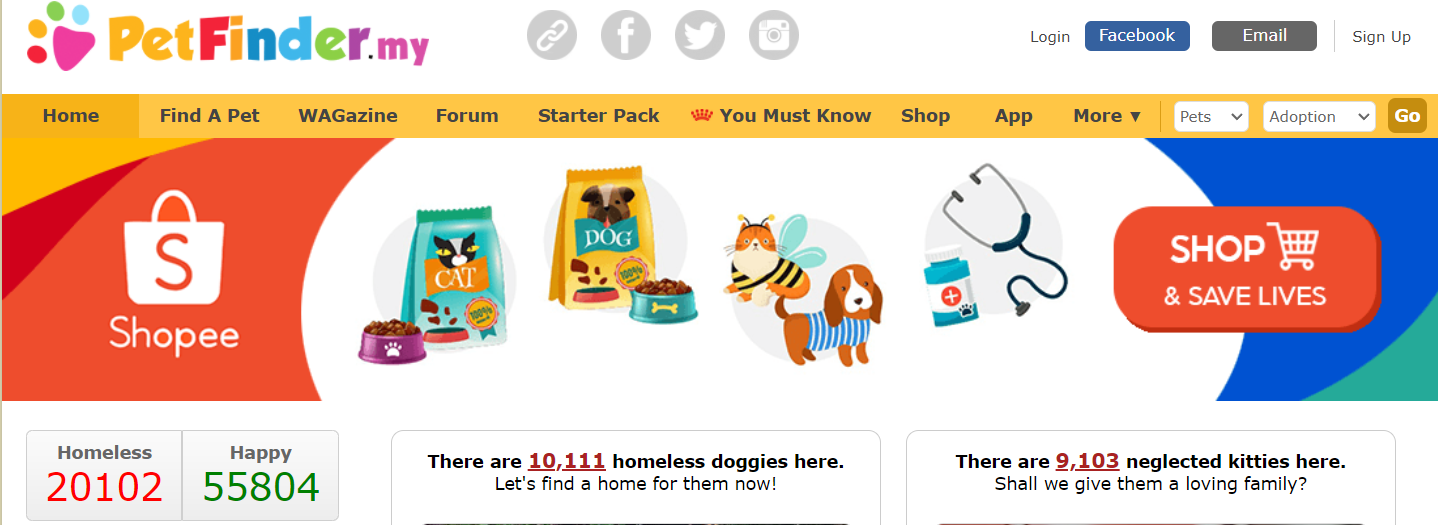

## Contents

- Load Dependancies
- Load & Extract/Clean Data
- DataBlock
- Training
- Determine how to score the predicted labels
- Submission

### Load Dependancies

This notebook uses **[fastai](https://github.com/fastai)** and **[timm](https://github.com/rwightman/pytorch-image-models/tree/master/timm)**

In [ ]:
!pip install '../input/timm034/timm-0.4.12-py3-none-any.whl' -qq

In [ ]:
!cp -r ../input/fmipackage/fmi-master/* ./

Disable any **FutureWarning**s

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [ ]:
import sys
from fastai.vision.all import *
import timm
from timm import create_model
from fmi.explore import *
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Suppress pandas **SettingWithCopyWarning** which potential indicates issues with chained assignments

In [ ]:
pd.options.mode.chained_assignment = None

Check the loaded versions

In [ ]:
system_info()

### Load & Extract/Clean Data

In [ ]:
source = Path('../input/petfinder-pawpularity-score')
train_csv = pd.read_csv(f'{source}/train.csv')
train_csv

Extract the metadata and get rid of any special characters

In [ ]:
meta = train_csv[['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group',
       'Collage', 'Human', 'Occlusion', 'Info', 'Blur']]

meta['multi'] = meta.apply(lambda x: x.index[x == 1].tolist(), axis=1)
meta['multi'] = meta['multi'].astype('string')

spec_chars = ["[", "]", "'", ",", ";"]

for char in spec_chars:
    meta['multi'] = meta['multi'].str.replace(char, '')

Create the updated training database

In [ ]:
meta_class = meta[['multi']]

train_csv['Id'] = train_csv['Id'].map(lambda x:str(source/'train'/x)+'.jpg')

path_df = train_csv[['Id']]

df = pd.concat([path_df, meta_class], axis=1)
df

### Create DataBlock

**fastai** allows for alot of customization. The concept of **presizing** is explained in detail [here](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb)

By default **fastai** uses the **Crop** method when resizing images but depending on the dataset that might not always be the best method to use.  We can compare the default (Crop) with Squish and Pad to see how they look within a batch.

In [ ]:
item_tfms = [Resize(224, method=ResizeMethod.Crop),
             Resize(224, method=ResizeMethod.Squish),
             Resize(224, method=ResizeMethod.Pad),
             RandomCrop(224)]
batch_tfms = [RandomResizedCrop(196), *aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)]

Compare how **Crop**, **Squish** and **Pad** resized images look within a batch and **set_seed** as a means of reproducibility

In [ ]:
for item in item_tfms:
    set_seed(7)
    paws = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms = item,
                   batch_tfms = batch_tfms)
    
    val = str(item); val_split = val.split(' ')
    title = (val_split[0], val_split[5], val_split[6])    
    print(title)
    dls = paws.dataloaders(df, bs=8)
    dls.show_batch(max_n=8, nrows=1)

We can see differences between the various methods and in this case using **Squish** displays the best results

In [ ]:
paws = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms = Resize(224, method=ResizeMethod.Squish),
                   #batch_tfms = [RandomResizedCrop(196), *aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)])
                   batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()]))

dls = paws.dataloaders(df, bs=32)
dls.show_batch(max_n=7, nrows=1)

### Training

Load the pre-trained weights from **timm**

In [ ]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
#!cp '../input/timm034/efficientnetv2_rw_m_agc-3d90cb1e.pth' '/root/.cache/torch/hub/checkpoints/efficientnetv2_rw_m_agc-3d90cb1e.pth'
!cp '../input/timm034/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [ ]:
def create_timm_body(arch:str, pretrained=True, cut=None):
    model = create_model(arch, pretrained=pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [ ]:
#body = create_timm_body('efficientnetv2_rw_m', pretrained=True)
#nf = num_features_model(body); nf
#head = create_head(nf, dls.c, concat_pool=True, first_bn=True, bn_final=True)
#model = nn.Sequential(body, head)
model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=dls.c)

Note on using **create_head**:
- by default it uses the pooling trick(**concat_pool = True**) where both adaptative average pooling and adaptive max pooling are used, switching this to **False** results in only adaptive average pooling being used.
- **first_bn** is also by default set to **True** - this creates a **BatchNorm** layer after Pooling + Flatten
- **bn_final** is also by default set to **True** - this creates a **BatchNorm** layer after Dropout + Linear

The **fastai** tutorials and various posts have mentioned how these all improve training

In [ ]:
#model[1]

When creating the **Learner** if the loss function and optimization function are not specified **fastai** will try to use the most appropriate functions

In [ ]:
learn = Learner(dls, 
                model, 
                metrics=[accuracy_multi],
                cbs = [ShowGraphCallback,\
                       SaveModelCallback(monitor='accuracy_multi',fname='best_acc',comp=np.greater, with_opt=True)]).to_fp16()

You can view them like so:

In [ ]:
print(learn.loss_func, learn.opt_func)

So in this case by default the loss function chosen is BCEWithLogitsLoss and the optimization function is Adam. In this case we will choose a different optimization function.

By default:

- **weight decay** is not added by default
- **weight decay** if specified is only applied to the BatchNorm layers and not the bias
- the **BatchNorm** layers are trained even when they are supposed to be frozen.

In this case we add weight decay(a L2 regularization technique and use Leslie 's value of wd=4e-3) and apply it to both the BatchNorm layers and the bias

In [ ]:
from fastai.metrics import rmse

In [ ]:
learn = Learner(dls, 
                model, 
                #opt_func = ranger,
                metrics=[accuracy_multi, rmse],
                cbs = [ShowGraphCallback,\
                       SaveModelCallback(monitor='accuracy_multi',fname='best_acc',comp=np.greater, with_opt=True)],
                 wd = 4e-3,
                 wd_bn_bias=False).to_fp16()

In [ ]:
learn.fine_tune(17, 1e-3)

### Determine how to score the predicted labels

In this experiment we will obtain importances from coefficients.  In this simple logic case we examine feature importances by examining the model’s coefficients. If the assigned coefficient is a large positive or negative number it has a positive or negative influence on the prediction.  And if the coefficient is zero, it does not have an impact on the prediction.

In [ ]:
X = train_csv[['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'Pawpularity']]
y = X.pop('Pawpularity')
X

Scale the inputs

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

ss = StandardScaler()
x_train_scaled = ss.fit_transform(x_train)
x_test_scaled = ss.transform(x_test)

As this is a classification problem we use Logistic Regression

In [ ]:
model = LogisticRegression()
model.fit(x_train_scaled, y_train)
attribute_importance = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': model.coef_[0]*100
})
attribute_importance = attribute_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,5))
ax = sns.barplot(x=attribute_importance['Attribute'], y=attribute_importance['Importance'], palette='rainbow_r')
plt.xlabel('Attribute', fontsize='x-large')
plt.ylabel('Importance', fontsize='x-large')
plt.yticks(fontweight='light', fontsize='x-large')
plt.xticks(rotation=45, fontweight='light', fontsize='x-large');

In [ ]:
attribute_importance

We will use the above values to get the **Pawpularity** predictions

### Submission

In [ ]:
test_imgs_path = f'{source}/test'
test_fns = get_image_files(test_imgs_path)

In [ ]:
learn.load('best_acc')

In [ ]:
learn.predict(test_fns[0])

The predictions will all be 0 because we do not have access to the images but we can see that the prediction is a 13 long vector.

We can test this by using one of the images from the validation dataset

In [ ]:
dls.valid_ds[2][0]

In [ ]:
dls.valid_ds[2][1]

In [ ]:
learn.predict(dls.valid_ds[2][0])

Now to get the predictions

In [ ]:
pred_list = []
for file in test_fns:
    p = learn.predict(file)
    pos_vals = int(sum(p[1]))
    if pos_vals == 0:
        pos_vals = 1
    else:
        pos_vals = pos_vals
           
    if 'Subject Focus' in p[0]: val = 5.4
    else: val = 0
    if 'Eyes' in p[0]: val1 = -17
    else: val1 = 0
    if 'Face' in p[0]: val2 = 8.7
    else: val2 = 0
    if 'Near' in p[0]: val3 = 10.1
    else: val3 = 0
    if 'Action' in p[0]: val4 = 8.5
    else: val4 = 0
    if 'Accessory' in p[0]: val5 = -21
    else: val5 = 0
    if 'Group' in p[0]: val6 = 14.9
    else: val6 = 0
    if 'Collage' in p[0]: val7 = -4.9
    else: val7 = 0
    if 'Human' in p[0]: val8 = 8.6
    else: val8 = 0
    if 'Occlusion' in p[0]: val9 = -5.3
    else: val9 = 0
    if 'Info' in p[0]: val10 = 4
    else: val10 = 0
    if 'Blur' in p[0]: val11 = -7.7
    else: val11 = 0
        
    final_one = val + val1 + val2 + val3 + val4 + val5 + val6 + val7 + val8 + val9 + val10 + val11    
    print(final_one)
    
    if final_one < 0:
        final_one = 0
    else: final_one = final_one
    
    final = float(final_one/pos_vals)
    print(final)
    pred_list.append(final)

And creating the submission file

In [ ]:
test_data = pd.DataFrame()
test_data['Id'] = [img[:-4]for img in os.listdir(test_imgs_path)]

test_data['Pawpularity'] = pred_list
test_data

In [ ]:
test_data.to_csv('submission.csv' , index=False)